In [ ]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["erddapy"]
_colab_install_missing_deps(deps)

# Read realtime data from IOOS Sensor Map via ERDDAP tabledap

Created: 2017-03-21

Updated: 2022-07-07

Web Map Services are a great way to find data you may be looking for in a particular geographic area.

Suppose you are exploring the [IOOS Sensor Map](https://sensors.ioos.us/#map),
you select Oxygen and click on the only returned value, the Moss Landing Marine Laboratories (MLML) station.

![sensor_map.png](https://user-images.githubusercontent.com/950575/178321765-74ed0562-b942-4d97-af8b-85158bc6488c.png)

One can download the data in multiple forms from the site, including generating an [ERDDAP URL](https://erddap.sensors.ioos.us/erddap/tabledap/mlml_mlml_sea.csv?time%2Cmole_concentration_of_dissolved_molecular_oxygen_in_sea_water%2Cmole_concentration_of_dissolved_molecular_oxygen_in_sea_water_qc_agg%2Cz&time%3E%3D2022-07-01T12%3A35%3A13Z&time%3C%3D2022-07-11T12%3A35%3A13Z) for the request.

These features makes Sensor map an extremely useful tool for quick data explorations but now imagine if you want automate that instead of exploring the Sensor Map interactively? Or if you want to make multiple small modification to your query? It would be very tedious and error prone to try that with the Sensor Map interface. The good news is that we cab automate that by querying the ERDDAP server directly.

First we need to instantiate a server object.

In [1]:
from erddapy import ERDDAP

server = "http://erddap.sensors.ioos.us/erddap"
e = ERDDAP(server=server, protocol="tabledap")

Now we can search for "dissolved oxygen moss landing" and inspect the dataset_ids.

In [2]:
import pandas as pd

url = e.get_search_url(search_for="dissolved oxygen moss landing", response="csv")

print(url)
df = pd.read_csv(url)
df

http://erddap.sensors.ioos.us/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=tabledap&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=(ANY)&variableName=(ANY)&minLon=(ANY)&maxLon=(ANY)&minLat=(ANY)&maxLat=(ANY)&minTime=&maxTime=&searchFor=dissolved+oxygen+moss+landing


,griddap,Subset,tabledap,Make A Graph,wms,files,Title,Summary,FGDC,ISO 19115,Info,Background Info,RSS,Email,Institution,Dataset ID
0,NaN,NaN,http://erddap.sensors.ioos.us/erddap/tabledap/...,http://erddap.sensors.ioos.us/erddap/tabledap/...,NaN,NaN,CeNCOOS in situ water quality monitoring using...,The Seawater intake station is maintained by M...,http://erddap.sensors.ioos.us/erddap/metadata/...,http://erddap.sensors.ioos.us/erddap/metadata/...,http://erddap.sensors.ioos.us/erddap/info/mlml...,https://sensors.ioos.us/#metadata/48035/station,http://erddap.sensors.ioos.us/erddap/rss/mlml_...,http://erddap.sensors.ioos.us/erddap/subscript...,Moss Landing Marine Laboratory,mlml_mlml_sea
1,NaN,NaN,http://erddap.sensors.ioos.us/erddap/tabledap/...,http://erddap.sensors.ioos.us/erddap/tabledap/...,NaN,NaN,CeNCOOS in situ water quality monitoring at Mo...,The Monterey shore station is maintained by Mo...,http://erddap.sensors.ioos.us/erddap/metadata/...,http://erddap.sensors.ioos.us/erddap/metadata/...,http://erddap.sensors.ioos.us/erddap/info/mlml...,https://sensors.ioos.us/#metadata/20362/station,http://erddap.sensors.ioos.us/erddap/rss/mlml_...,http://erddap.sensors.ioos.us/erddap/subscript...,Moss Landing Marine Laboratory,mlml_monterey


Interesting, we found two dataset_ids instead of the one showed in the sensor map!
Let's investigate the datasets we found and try to figure out why there is a discrepancy.

In [3]:
for k, v in df[["Dataset ID", "Title", "Summary"]].T.items():
    dataset_id = v["Dataset ID"]
    title = v["Title"]
    summary = v["Summary"].replace("\\n", "\n")
    print(f"{dataset_id}: {title}\n\n{summary}\n")

mlml_mlml_sea: CeNCOOS in situ water quality monitoring using the seawater input for Moss Landing Marine Laboratory.

The Seawater intake station is maintained by Moss Landing Marine Laboratories who share the data with CeNCOOS. Data collected includes temperature, conductivity, salinity, fluorescence, beam attenuation, transmission, dissolved oxygen, dissolved organic saturation, pH, and tide height. Seawater data observations are collected from raw seawater drawn through an intake pipe. The pipe intake opening is located at 36.8025N and 121.7915W and is ~16.6m (54.4ft) below MLLW. The seawater sensors are cleaned of biofouling agents on a weekly/twice-weekly interval, though some data drift can be observed in transmission, beam attenution, and fluorescence. These nearshore sensors are part of the Central and Norther California Ocean Observing System (CeNCOOS). They measure various water quality parameters at fixed points along the California coast.

cdm_data_type = TimeSeries
VARIABL

The Sensor map returned only the dataset_id `mlml_mlml_sea` which corresponds to the CeNCOOS in situ water quality monitoring using the seawater input for Moss Landing Marine Laboratory. However, we also got the dataset_id for `mlml_monterey`, or the commercial wharf water quality monitoring.

Let's request the ERDDAP info on the latter to try to understand why it is available on the server but did not make into the Sensor Map. We usually suspect some sort of cut off due to the time coverage.

In [4]:
df = pd.read_csv(e.get_info_url(dataset_id="mlml_monterey", response="csv"))

df.loc[df["Attribute Name"] == "time_coverage_end"]

,Row Type,Variable Name,Attribute Name,Data Type,Value
69,attribute,NC_GLOBAL,time_coverage_end,String,2019-11-29T15:45:00Z


Bingo! Looks like station is no longer collecting data.
The sensor map only shows real-time observations (past 4-hours).

For the sake of simplicity let's use only the `mlml_mlml_sea` and download the last month of data.

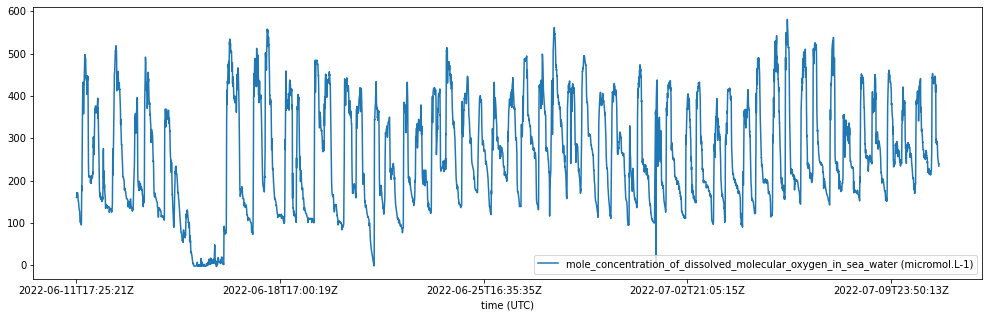

In [5]:
e.dataset_id = "mlml_mlml_sea"
e.variables = ["time", "mole_concentration_of_dissolved_molecular_oxygen_in_sea_water"]
e.constraints = {"time>=": "now-30days"}

df = e.to_pandas(index_col="time (UTC)")
ax = df.plot(figsize=(17, 5));

We hope this example demonstrate the flexibility of direct requests to the ERDDAP server used in the Sensor Map.
In this notebook we:

- Search the server with keywords.
- Found dataset_ids and checked their metadata.
- Identified the dataset_id of interested and request data at a specific time period.